# AirBNB Singapore - CRISP-DM analysis
#### AirBnB Singaore - a short analysis and interpretation of the world's most famous housing market for people on the move. 
The CRISP-DM Process is split into 6 parts: Business Understanding, Data Understanding, Data Preparation, Modeling, Evaluation and finally, deployment.

Throughout this notebook, the steps taken illustrate this approach, where the following questions are answered: <br> <br>
### Business Understanding <br>
AirBnB datasets are interesting for several reasons. But choosing Singapore has its own qualities of interest. <br>
i. It is a city-state with several tourist spots including an entire island to which you can take the monorail, to get to Universal Studios. This prompts an analyst who's given an AirBnB dataset, what makes Singapore's market interesting, and what insights can we derive out of it? <br> 
As a tourist, you would want to know where to stay to maximize utility. As a host, you would want to know which qualities of your listing are people willing to pay for the most? <br> <br>
For this reason: the business undertstanding of this project is the following questions:
1. How well can we predict the price of an AirBnB listing? <br>
1.1. What aspect relates to price the most? <br>
1.2. Does price have a regional tendency (is the price generally likely to be higher in one region than the other? <br>
2. Which neighbourhoods of Singapore gets the most "positive" reviews, and what insights can we derive from this result? <br>
2.1. Is there a relationship between prices and "positive" reviews? <br>
3. How well can we predict if a listing on average gets positive reviews? 
### Data Understanding <br>
From http://insideairbnb.com/get-the-data.html, the data for different listings, their calendars and extensive reviews dataset is obtained and used. <br> <br>

In [1]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.image as mpimg
import math
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nit61\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# The listings dataset is huge, with several irrelevant variables. 
# Hence, the separation of the variables in a list, and importing just this.
listing_cols = ['host_id','host_response_rate',
               'host_acceptance_rate', 'host_is_superhost',
               'host_listings_count', 'host_has_profile_pic',
               'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
               'latitude', 'longitude',
               'property_type', 'room_type',
               'accommodates', 'bedrooms','beds',
               'amenities', 'price',
               'availability_365', 'number_of_reviews',
               'review_scores_value', 'reviews_per_month']
# Reading the datasets
listings = pd.read_csv('listings.csv', usecols = listing_cols)
reviews = pd.read_csv('reviews.csv')
calendar = pd.read_csv('calendar.csv')
listings.head()

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,...,room_type,accommodates,bedrooms,beds,amenities,price,availability_365,number_of_reviews,review_scores_value,reviews_per_month
0,266763,100%,NaN,f,2.0,t,Woodlands,North Region,1.44255,103.79580,...,Private room,1,1.0,1.0,"[""Washer"", ""Elevator"", ""Wifi"", ""TV"", ""Cable TV...",$82.00,365,1,8.0,0.01
1,227796,NaN,NaN,f,1.0,t,Bukit Timah,Central Region,1.33235,103.78521,...,Private room,2,1.0,1.0,"[""Essentials"", ""Washer"", ""Wifi"", ""TV"", ""Elevat...",$80.00,365,18,9.0,0.23
2,266763,100%,NaN,f,2.0,t,Woodlands,North Region,1.44246,103.79667,...,Private room,1,1.0,1.0,"[""Washer"", ""Elevator"", ""Wifi"", ""TV"", ""Kitchen""...",$68.00,365,20,9.0,0.18
3,367042,100%,100%,f,8.0,t,Tampines,East Region,1.34541,103.95712,...,Private room,6,2.0,3.0,"[""Wifi"", ""Dryer"", ""Private entrance"", ""Smoke a...",$179.00,365,20,9.0,0.19
4,367042,100%,100%,f,8.0,t,Tampines,East Region,1.34567,103.95963,...,Private room,3,1.0,1.0,"[""Essentials"", ""Washer"", ""Wifi"", ""TV"", ""Kitche...",$95.00,365,24,8.0,0.21


In [3]:
# Three of our variables are in string format that needs to be 
# converted to numeric.
def str_to_num(series):
    '''
    INPUT:
    series - dataframe column name
    OOUTPUT:
    cleaned off the string chars and converted to float
    '''
    series = series.str.replace('$','')
    series = series.str.replace(',','')
    series = series.str.replace('%','')
    series = series.astype('float')
    return series
# Implementation of the function above. 
acceptance_rate = listings['host_acceptance_rate']
response_rate = listings['host_response_rate']
price = listings['price']
listings['host_acceptance_rate'] = str_to_num(acceptance_rate)
listings['host_response_rate'] = str_to_num(response_rate)
listings['price'] = str_to_num(price)

In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 21 columns):
host_id                         4492 non-null int64
host_response_rate              3893 non-null float64
host_acceptance_rate            3871 non-null float64
host_is_superhost               4490 non-null object
host_listings_count             4490 non-null float64
host_has_profile_pic            4490 non-null object
neighbourhood_cleansed          4492 non-null object
neighbourhood_group_cleansed    4492 non-null object
latitude                        4492 non-null float64
longitude                       4492 non-null float64
property_type                   4492 non-null object
room_type                       4492 non-null object
accommodates                    4492 non-null int64
bedrooms                        4106 non-null float64
beds                            4437 non-null float64
amenities                       4492 non-null object
price                           4492 non

Thus begins...
### Data preparation and Descriptive Analyses

In [5]:
# The amenities column is a list within a column, 
# stored as a string. For the analysis, I want the number of 
# amenities in each listing. This function does just that.
def amenities(amen):
    '''
    Input: amenities columns in listings dataframe
    Output: removes the nested list, and counts the elements
    in each list observation, to get number of amenities
    per listing.
    '''
    amen = listings[amen]
    stripped = [i.strip('][').split(', ') for i in amen]
    num_elements = [len(j) for j in stripped]
    listings['amenities_count'] = num_elements
    return listings['amenities_count']
amenities('amenities')

0        6
1       11
2        8
3       25
4       20
        ..
4487    30
4488    30
4489    30
4490    27
4491    28
Name: amenities_count, Length: 4492, dtype: int64

### Now for some data analysis and visualizations
##### (Along with some cleaning of course)

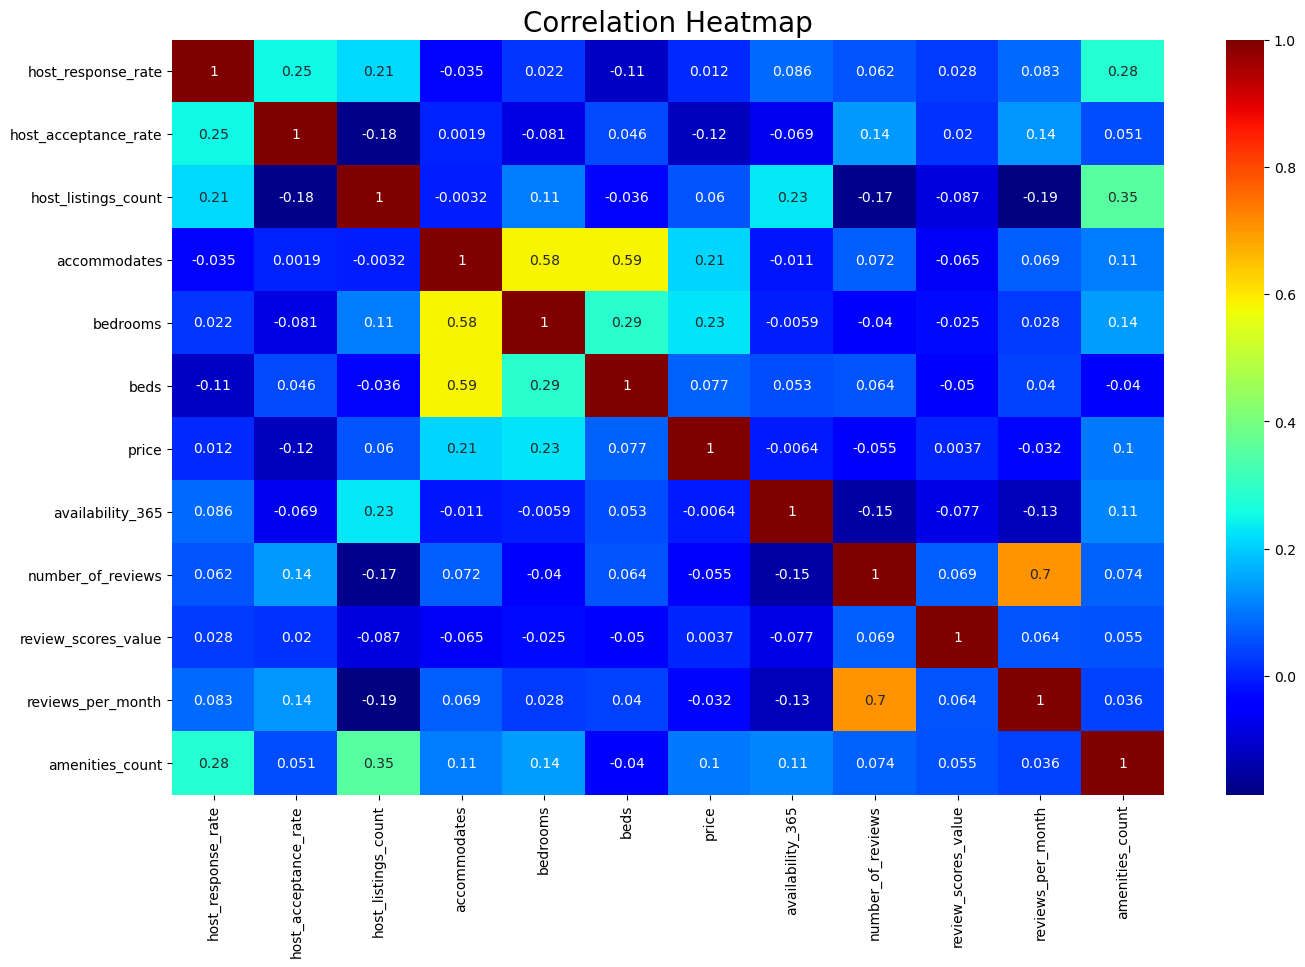

In [6]:
# Descriptive analysis - Correlation analysis through heatmap
plt.figure(figsize = (16,10), dpi = 100)
plt.style.use('default')
sns.heatmap(listings.select_dtypes(include=['integer', 'floating']).drop(['host_id',
           'latitude','longitude'], 1).corr(), annot = True, 
           cmap = plt.get_cmap('jet'), cbar = True)
plt.title('Correlation Heatmap', fontsize = 20)
plt.savefig('Correlation_heatmap.png', dpi = 150)
plt.show()

##### 1. The highest correlation is seen between reviews_per_month and number_of_reviews. This might create multicollinearity problems in the linear regression model to predict price. <br>
##### 2. Price is correlated the highestwith the number of bedrooms and number of people a listing can accommodate - both of them naturally. <br>
##### 3. Notice how bedrooms is correlated with price more than "beds" are. This may be due to the fact that the number of beds being high could also indicate that the listing is a shared room, which typically has a lower price.

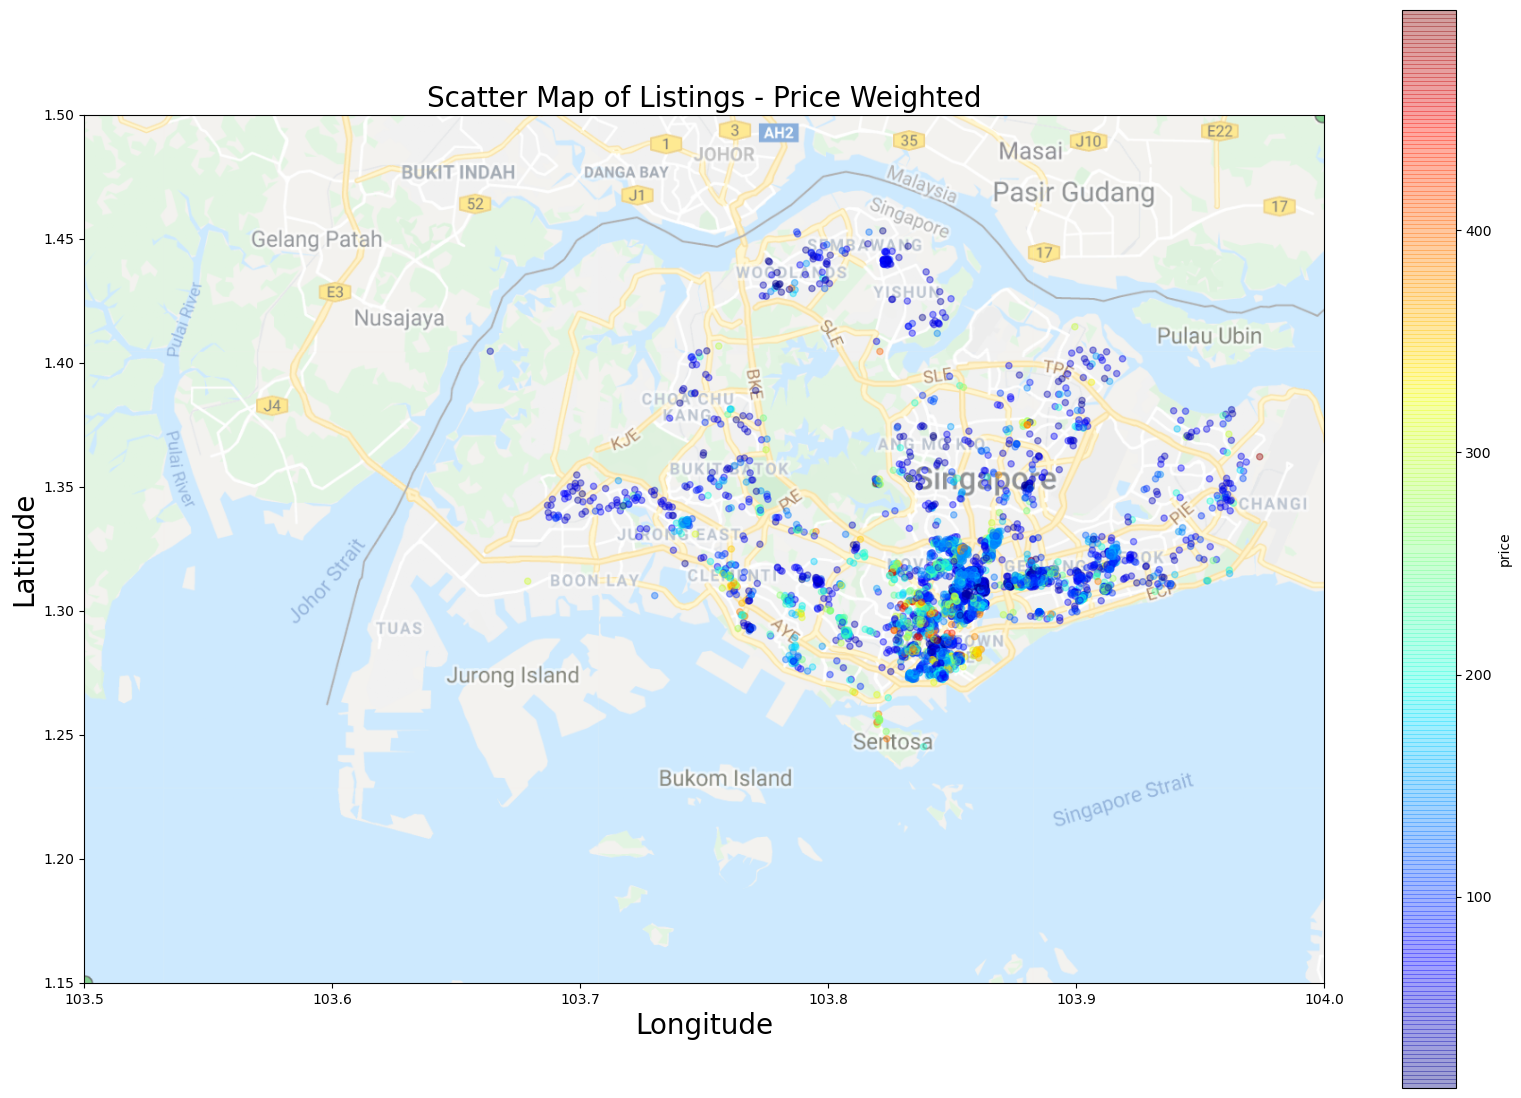

In [8]:
singapore_png = mpimg.imread('raw_singapore.png')

# Scatter map of the listings and their density, weighted by price.
pricing = listings[listings['price'] < 500] # Removing observations with 500 + price
# to give a better picture of the density.
ax = pricing.plot(kind = 'scatter',
                  x = 'longitude',
                  y = 'latitude',
                  figsize = (20,14),
                  c = 'price', 
                  cmap = plt.get_cmap('jet'),
                  colorbar = True,
                  alpha = 0.375)
plt.imshow(singapore_png,
           extent = [103.5,104,1.15, 1.50],
           alpha = 0.6)
plt.xlabel('Longitude', fontsize = 20)
plt.ylabel('Latitude', fontsize = 20)
plt.xlim(103.5, 104)
plt.ylim(1.15, 1.50)
plt.title('Scatter Map of Listings - Price Weighted', fontsize = 20)
plt.savefig('Singapore Listings Map.png', dpi = 150)
plt.show()

We see that the bay area of Singapore to the South has higher frequency of listings, along with higher prices: this is expected since those neighbourhoods host Singapore's most attractive tourist destinations, such as Sentosa, Merlion, etc. (and the building with the ship on top)

In [9]:
# Creating neighbourhoods and their average prices dataframe
neighbourhood = listings.groupby(['neighbourhood_cleansed']).mean()['price']
neighbourhood = pd.DataFrame(neighbourhood.sort_values(ascending=False))
neighbourhood = neighbourhood.reset_index().rename(columns = {'neighbourhood_cleansed':'Neighbourhoods'})
neighbourhood.head(10)

,Neighbourhoods,price
0,Tuas,10286.000000
1,Southern Islands,1447.923077
2,Marina South,378.500000
3,Pasir Ris,363.413793
4,Orchard,347.987179
5,Pioneer,305.000000
6,Changi,299.000000
7,Sungei Kadut,290.000000
8,Tanglin,268.129412
9,Downtown Core,200.316993


In [10]:
# Creating neighbourhoods and their umber of listings dataframe
count = listings.groupby(['neighbourhood_cleansed']).count()['host_id']
count = pd.DataFrame(count.sort_values(ascending=False))
count = count.reset_index().rename(columns = {'neighbourhood_cleansed':'Neighbourhoods',
                                             'host_id':'Frequency'})
count.head()

,Neighbourhoods,Frequency
0,Kallang,627
1,Novena,419
2,Geylang,400
3,Outram,346
4,Rochor,321


In [11]:
# Merging the two datasets
neighbourhood = neighbourhood.merge(count, on = 'Neighbourhoods')
neighbourhood = neighbourhood.sort_values(by = 'Frequency', ascending = False)
neighbourhood

,Neighbourhoods,price,Frequency
32,Kallang,113.558214,627
18,Novena,168.400955,419
23,Geylang,141.105000,400
27,Outram,128.049133,346
24,Rochor,138.862928,321
9,Downtown Core,200.316993,306
15,Bukit Merah,176.600000,215
21,Bedok,159.592417,211
20,River Valley,161.938389,211
16,Singapore River,175.510204,147


In [12]:
# We'll remove outlier neighbourhoods from the new dataframe
# Note that by removing 'Tuas', we also remove a price outlier
neighbourhood = neighbourhood[neighbourhood['Frequency'] > 10]
neighbourhood.set_index('Neighbourhoods', inplace = True)

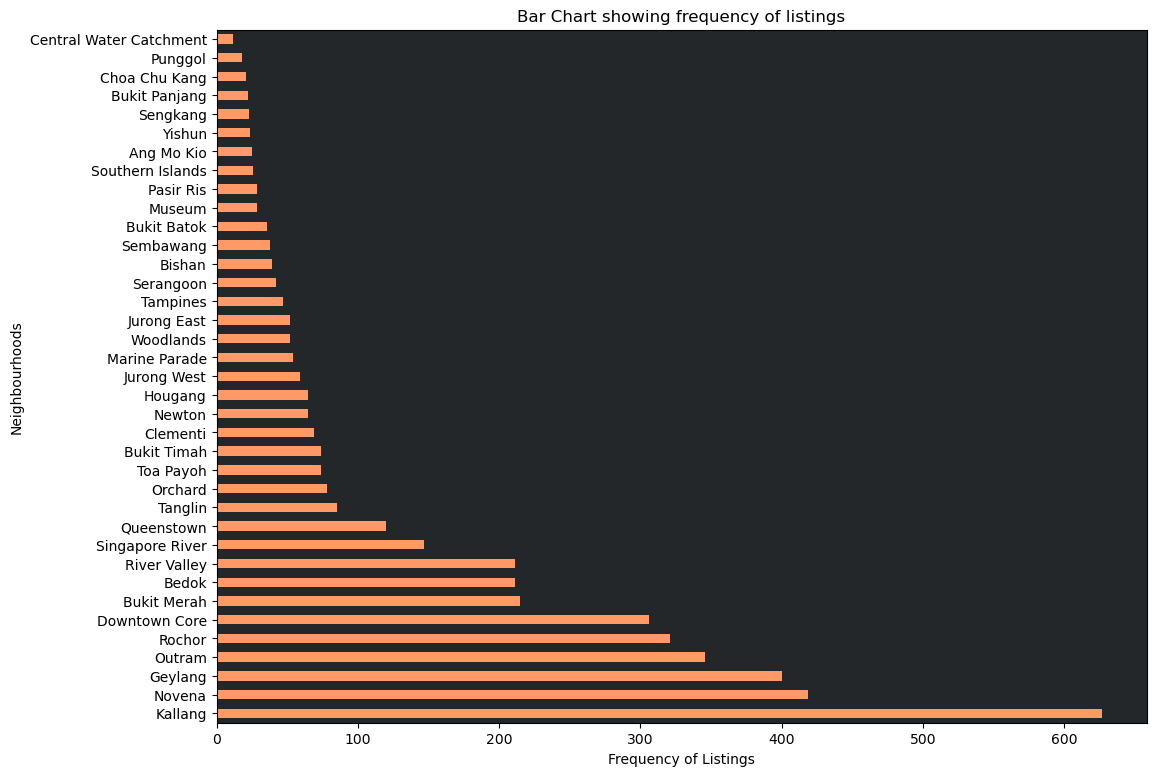

In [13]:
# Horizontal bar of frequency of listings in neighbourhoods
plt.style.use('default')
ax = neighbourhood['Frequency'].plot(kind = 'barh',
                               figsize = (12,9),
                               grid = False,
                               color = '#ff9966'
                               )
ax.set_facecolor('#23272A')
plt.xlabel('Frequency of Listings')
plt.title('Bar Chart showing frequency of listings')
plt.show()

In [14]:
## All things remaining constant, let us check the correlation between frequency
# and the prices.
neighbourhood[['Frequency', 'price']].corr()

,Frequency,price
Frequency,1.000000,-0.108469
price,-0.108469,1.000000


We see that more the listings in a neighbourhood, a weak correlation parameter suggests lesser price in the neighbourhood. Demand and supply equilibrium? 

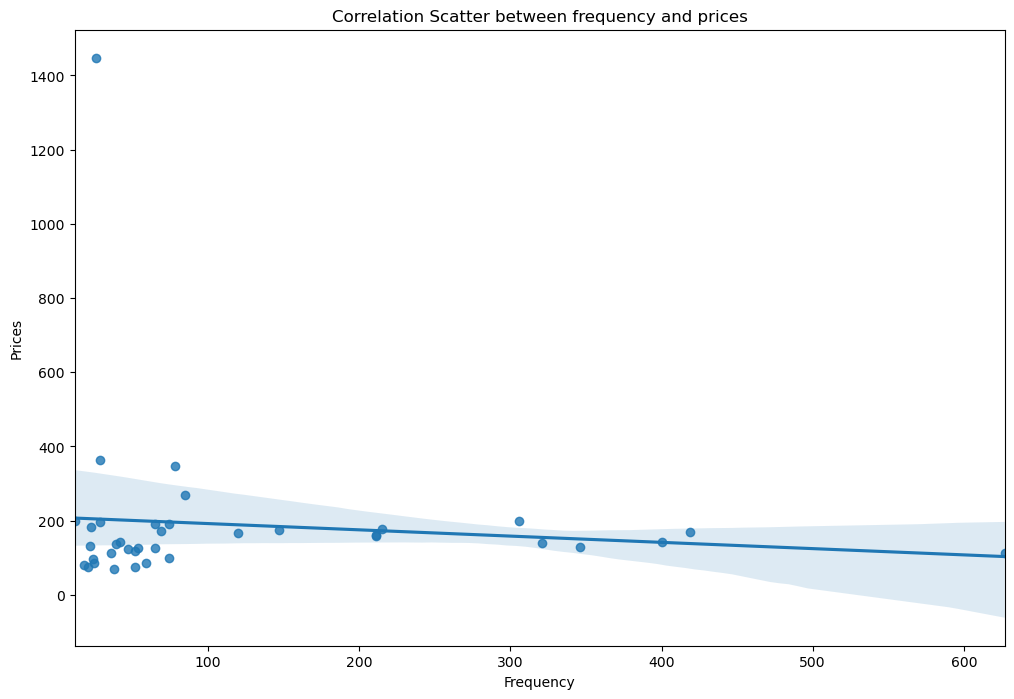

In [15]:
# The simple scatter plot shows the relationship between frequency of listings
# in a neighbourhood and the average prices there.
plt.figure(figsize=(12,8))
sns.regplot(x = neighbourhood['Frequency'],
            y = neighbourhood['price'])
plt.title('Correlation Scatter between frequency and prices')
plt.ylabel('Prices')
plt.show()
# This is basically the correlation visualized in a regression plot.

In [16]:
print('Average listings per neighbourhood: {}'.format(np.mean(neighbourhood['Frequency'])))

Average listings per neighbourhood: 121.10810810810811


In [17]:
# Removing the outlier neighbourhoods from the main listings dataframe.
neighbour_rows = ['Tuas', 'Pioneer', 'Sungei Kadut', 'Marina South',
                 'Changi', 'Mandai', 'Western Water Catchment']
for i in neighbour_rows:
    listings = listings[listings['neighbourhood_cleansed'] != i]

In [18]:
print(listings.shape)
listings.info()

(4481, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4481 entries, 0 to 4491
Data columns (total 22 columns):
host_id                         4481 non-null int64
host_response_rate              3885 non-null float64
host_acceptance_rate            3866 non-null float64
host_is_superhost               4479 non-null object
host_listings_count             4479 non-null float64
host_has_profile_pic            4479 non-null object
neighbourhood_cleansed          4481 non-null object
neighbourhood_group_cleansed    4481 non-null object
latitude                        4481 non-null float64
longitude                       4481 non-null float64
property_type                   4481 non-null object
room_type                       4481 non-null object
accommodates                    4481 non-null int64
bedrooms                        4096 non-null float64
beds                            4426 non-null float64
amenities                       4481 non-null object
price                        

In [19]:
# Percentage of missing values in the listings dataframe
np.round((listings.isnull().sum()/listings.shape[0])*100, 2) 

host_id                          0.00
host_response_rate              13.30
host_acceptance_rate            13.72
host_is_superhost                0.04
host_listings_count              0.04
host_has_profile_pic             0.04
neighbourhood_cleansed           0.00
neighbourhood_group_cleansed     0.00
latitude                         0.00
longitude                        0.00
property_type                    0.00
room_type                        0.00
accommodates                     0.00
bedrooms                         8.59
beds                             1.23
amenities                        0.00
price                            0.00
availability_365                 0.00
number_of_reviews                0.00
review_scores_value             41.58
reviews_per_month               40.10
amenities_count                  0.00
dtype: float64

###### Question 1 is analyzed and solved now: <br>
##### The categorical variables are one-hot-encoded, and the missing values are imputed in three different ways. 

In [20]:
# One-hot encoding the categorical variables in the listings dataframe
# and merging them with the listings dataframe for linear regression
df = pd.concat([listings.drop(['host_is_superhost','host_has_profile_pic',
                              'neighbourhood_group_cleansed', 'room_type'], axis = 1),
               pd.get_dummies(listings[['host_is_superhost','host_has_profile_pic',
                                       'neighbourhood_group_cleansed','room_type']])], axis = 1)

In [21]:
df.head()

,host_id,host_response_rate,host_acceptance_rate,host_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bedrooms,...,host_has_profile_pic_t,neighbourhood_group_cleansed_Central Region,neighbourhood_group_cleansed_East Region,neighbourhood_group_cleansed_North Region,neighbourhood_group_cleansed_North-East Region,neighbourhood_group_cleansed_West Region,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,266763,100.0,NaN,2.0,Woodlands,1.44255,103.79580,Private room in apartment,1,1.0,...,1,0,0,1,0,0,0,0,1,0
1,227796,NaN,NaN,1.0,Bukit Timah,1.33235,103.78521,Private room in apartment,2,1.0,...,1,1,0,0,0,0,0,0,1,0
2,266763,100.0,NaN,2.0,Woodlands,1.44246,103.79667,Private room in apartment,1,1.0,...,1,0,0,1,0,0,0,0,1,0
3,367042,100.0,100.0,8.0,Tampines,1.34541,103.95712,Private room in villa,6,2.0,...,1,0,1,0,0,0,0,0,1,0
4,367042,100.0,100.0,8.0,Tampines,1.34567,103.95963,Private room in house,3,1.0,...,1,0,1,0,0,0,0,0,1,0


In [22]:
# Creating a dataframe with just the numerical variables
num_vars = df.select_dtypes(include=['integer','float'])

In [23]:
num_vars.columns
# The variables not relevant to predict price are dropped here
num_vars = num_vars.drop(['host_id', 'latitude','longitude','bedrooms','number_of_reviews'], axis = 1)
num_vars.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,beds,price,availability_365,review_scores_value,reviews_per_month,amenities_count,...,host_has_profile_pic_t,neighbourhood_group_cleansed_Central Region,neighbourhood_group_cleansed_East Region,neighbourhood_group_cleansed_North Region,neighbourhood_group_cleansed_North-East Region,neighbourhood_group_cleansed_West Region,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,100.0,NaN,2.0,1,1.0,82.0,365,8.0,0.01,6,...,1,0,0,1,0,0,0,0,1,0
1,NaN,NaN,1.0,2,1.0,80.0,365,9.0,0.23,11,...,1,1,0,0,0,0,0,0,1,0
2,100.0,NaN,2.0,1,1.0,68.0,365,9.0,0.18,8,...,1,0,0,1,0,0,0,0,1,0
3,100.0,100.0,8.0,6,3.0,179.0,365,9.0,0.19,25,...,1,0,1,0,0,0,0,0,1,0
4,100.0,100.0,8.0,3,1.0,95.0,365,8.0,0.21,20,...,1,0,1,0,0,0,0,0,1,0


In [24]:
# Let us have another look at the null values percentages
nulls_perc = np.round((num_vars.isnull().sum()/num_vars.shape[0])*100, 2)
nulls_perc

host_response_rate                                13.30
host_acceptance_rate                              13.72
host_listings_count                                0.04
accommodates                                       0.00
beds                                               1.23
price                                              0.00
availability_365                                   0.00
review_scores_value                               41.58
reviews_per_month                                 40.10
amenities_count                                    0.00
host_is_superhost_f                                0.00
host_is_superhost_t                                0.00
host_has_profile_pic_f                             0.00
host_has_profile_pic_t                             0.00
neighbourhood_group_cleansed_Central Region        0.00
neighbourhood_group_cleansed_East Region           0.00
neighbourhood_group_cleansed_North Region          0.00
neighbourhood_group_cleansed_North-East Region  

###### The way the different missing values are imputed, are: <br>
1. host_acceptance_rate, host_responce_rate, host_listings_count - mean value of the column is filled. 
Although a better way would be to impute using the average value of each listing based on the neighbourhood they are listed. But it is not a strong assumption to make, as well as not simple. <br>
2. Missing data for number of beds are imputed with the mode value of the same. Although, were the missing data more than 10% of the column, imputation can be made based on the average of the respective room type. For example: if the missing value is for a private room, it is imputed with the average number of beds for a private room in Singapore.
3. reviews_per_month and review_scores_value have over 40% of the data missing. There is no reasonable imputation method that can satisfy the gap. Removing the data would prove detrimental in the analysis to predict price as well. So, two dummy_na columns for the two variables are created. 

In [25]:
# Imputing missing values using the mean of the column.
def fill_mean(dataframe, column):
    '''
    Input - dataframe, and the column to impute.
    Output - the column's null values are imputed
    to fill the mean of the column.
    '''
    dataframe[column] = dataframe[column].fillna(dataframe[column].mean(), axis = 0)
    return dataframe[column]

fill_mean(num_vars, 'host_acceptance_rate')
fill_mean(num_vars, 'host_response_rate')
fill_mean(num_vars, 'host_listings_count')
print('Mean Value filled for the three variables!!!')

Mean Value filled for the three variables!!!


In [26]:
# The number of beds in a listing is an integer, and is imputed with the mode
num_vars['beds'].fillna(num_vars['beds'].mode()[0], inplace = True)

# There are two review columns for which we need to impute the data
# Since there are 40% + missing data, I think it is appropriate to convert the 
# missing data into zeroes and add two new dummy_na columns. 
num_vars['permonth_null'] = ""
num_vars['value_null'] = ""
# The loop that goes through all rows in the two review columns
# and fills the two new dummy variable columns with 1 if the review
# column is NaN, otherwise 0. This lets us know if the missing data 
# had any significant information that predicts price.
for index, rows in num_vars.iterrows():
    flag = num_vars.at[index, 'review_scores_value']
    flag2 = num_vars.at[index, 'reviews_per_month']
    if math.isnan(flag):
        num_vars.at[index, 'value_null'] = 1
        num_vars.at[index, 'review_scores_value'] = 0
    else:
        num_vars.at[index, 'value_null'] = 0
    if math.isnan(flag2):
        num_vars.at[index, 'permonth_null'] = 1
        num_vars.at[index, 'reviews_per_month'] = 0
    else:
        num_vars.at[index, 'permonth_null'] = 0

num_vars.isnull().sum()

host_response_rate                                0
host_acceptance_rate                              0
host_listings_count                               0
accommodates                                      0
beds                                              0
price                                             0
availability_365                                  0
review_scores_value                               0
reviews_per_month                                 0
amenities_count                                   0
host_is_superhost_f                               0
host_is_superhost_t                               0
host_has_profile_pic_f                            0
host_has_profile_pic_t                            0
neighbourhood_group_cleansed_Central Region       0
neighbourhood_group_cleansed_East Region          0
neighbourhood_group_cleansed_North Region         0
neighbourhood_group_cleansed_North-East Region    0
neighbourhood_group_cleansed_West Region          0
room_type_En

###### Linear regression and Ridge regression models are run and compared.

In [27]:
X = num_vars.drop('price', 1)
y = num_vars.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
lm = LinearRegression()
ridge = Ridge()

In [28]:
# Linear Regression fitting, predicting and evaluating.
lm_model = lm.fit(X_train, y_train)
predictions_lm = lm_model.predict(X_test)
accuracy_lm = r2_score(y_test, predictions_lm)
print('The Goodness of the fit of the model is: {}'.format(accuracy_lm))
rmse = np.sqrt(mean_squared_error(y_test, predictions_lm))
print('The Root Mean Squared Error is: {}'.format(rmse))

The Goodness of the fit of the model is: 0.1557394277655294
The Root Mean Squared Error is: 196.09088997959506


In [29]:
# Ridge Model fitting, predicting and evaluating
ridge_model = ridge.fit(X_train, y_train)
predictions_ridge = ridge_model.predict(X_test)
accuracy_ridge = r2_score(y_test, predictions_ridge)
print('The Goodness of fit of the model is: {}'.format(accuracy_ridge))
rmse_ridge = np.sqrt(mean_squared_error(y_test, predictions_ridge))
print('The Root Mean Squared Error is: {}'.format(rmse_ridge))

The Goodness of fit of the model is: 0.15580584611032855
The Root Mean Squared Error is: 196.0831765502744


In [30]:
def coef_weights(coeff, X_train):
    '''
    INPUT:
    coeff - coefficients of the linear regression model
    X_train - to use the column names of the training data
    OUTPUT:
    coefs_df = dataframe with the coefficients of different features
    
    The dataframe tells us how much influence each feature has.
    Along with the weights attached to each variable, is the variable
    name, to reference it. 
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values(by = 'abs_coefs', ascending=False)
    return coefs_df
coef_df = coef_weights(lm_model.coef_, X_train)
coef_df.head(20)

,est_int,coefs,abs_coefs
14,neighbourhood_group_cleansed_East Region,54.668737,54.668737
18,room_type_Entire home/apt,53.832520,53.832520
21,room_type_Shared room,-40.202346,40.202346
22,permonth_null,39.864408,39.864408
3,accommodates,27.284937,27.284937
23,value_null,25.757494,25.757494
16,neighbourhood_group_cleansed_North-East Region,-23.464630,23.464630
15,neighbourhood_group_cleansed_North Region,-20.146929,20.146929
11,host_has_profile_pic_f,14.086520,14.086520
17,neighbourhood_group_cleansed_West Region,-13.709368,13.709368


###### Question 1: 
1. We can predict the price of a listing with 15.5% accuracy according to the linear model. <br> <br>
1.1. & 1.2. The likelihood of a listing being location in the Eastern region correlates with price the most. The neighbourhood tendencies of price is clear. From the map above, the Central and Eastern regions of Singapore are the most dense in terms of tourist attractions, and consequently, more frequency in listings too. The likelihood of price being higher if a listing is located in East is positive and high. 

In [31]:
ridge_coefs = coef_weights(ridge_model.coef_, X_train)
ridge_coefs.head(20)

,est_int,coefs,abs_coefs
14,neighbourhood_group_cleansed_East Region,54.668737,54.668737
18,room_type_Entire home/apt,53.832520,53.832520
21,room_type_Shared room,-40.202346,40.202346
22,permonth_null,39.864408,39.864408
3,accommodates,27.284937,27.284937
23,value_null,25.757494,25.757494
16,neighbourhood_group_cleansed_North-East Region,-23.464630,23.464630
15,neighbourhood_group_cleansed_North Region,-20.146929,20.146929
11,host_has_profile_pic_f,14.086520,14.086520
17,neighbourhood_group_cleansed_West Region,-13.709368,13.709368


Similar to the linear regression model, the likelihood of price being higher given a listing is located in the Eastern and Central region is high (weakly for Central), and lower prices for listings in the Northern and Northeastern Singapore. Other natural evidences are higher prices for an entire apartment listing, as opposed to lower prices for a shared room.

#### Questions 2 & 3:
##### For the following two questions, calendar data and reviews data is used. The following section of the notebook is structured as follows: <br>
1. Data cleaning and preparation for the calendar dataset. <br>
2. Data cleaning and preparation for the reviews dataset. <br>
2.1. Using the Natural Language Tooklit (NLTK) and regular expressions (re), the reviews are cleaned and then a sentiment score is derived using the Vader Sentiment Intensity Analyzer, and then the average of this sentiment is taken, grouped by listing. <br>
2.2. This is then merged with the calendar data set, on the common listing_id variable. <br>
3. The merged data set is then combined with the num_vars dataframe, to have a consolidated dataframe wherein we can analyze the relationship between the listing properties and the sentiment of their reviews.

In [32]:
# Take a look at the calendar dataset
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1838622,2020-10-26,t,$90.00,$90.00,2,1125
1,1838622,2020-10-27,t,$90.00,$90.00,2,1125
2,1838622,2020-10-28,t,$90.00,$90.00,2,1125
3,1838622,2020-10-29,t,$90.00,$90.00,2,1125
4,1838622,2020-10-30,t,$108.00,$108.00,2,1125


In [33]:
# Some data cleaning in the calendar data set
calendar['date'] = pd.to_datetime(calendar['date'])
prices = calendar['price']
adjusted_prices = calendar['adjusted_price']

# Converting the price column to a float variable once again
calendar['price'] = str_to_num(prices)
calendar['adjusted_price'] = str_to_num(adjusted_prices)

In [34]:
# Data exploration in the columns of Calendar. 
dates = calendar['date'].nunique()
missing_availability = sum(calendar.groupby('listing_id')['available'].count() != 365)
missing_prices = sum(calendar.groupby('listing_id')['price'].count() != 365)

print ("There are", dates, "days in the dataset")
print ("There are", missing_availability, "rows of no 'availability'")
print ("There are", missing_prices, "rows missing prices")

There are 365 days in the dataset
There are 0 rows of no 'availability'
There are 0 rows missing prices


In [35]:
# Converted the availability column to boolean
calendar['available'] = calendar['available'] == 't'
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1838622,2020-10-26,True,90.0,90.0,2,1125
1,1838622,2020-10-27,True,90.0,90.0,2,1125
2,1838622,2020-10-28,True,90.0,90.0,2,1125
3,1838622,2020-10-29,True,90.0,90.0,2,1125
4,1838622,2020-10-30,True,108.0,108.0,2,1125


In [36]:
# Getting the number of days available and percentage available
available = calendar[['listing_id',
                      'available']].groupby('listing_id').sum().rename(columns={'available':'days_available'})
available['availability_perc'] = available.apply(lambda x: round((x/365)* 100, 2))
available.head()

,days_available,availability_perc
listing_id,,
49091,365.0,100.0
50646,365.0,100.0
56334,365.0,100.0
71609,365.0,100.0
71896,365.0,100.0


In [37]:
# Obtaining the pricing patterns of each listing from the calendar dataset
# Calculating the maximum, mininmum, average and the price variations for each listing.
price = calendar[['listing_id', 'price']].groupby('listing_id').max().rename(columns={"price": "max_price"})
price['min_price'] = calendar[['listing_id', 'price']].groupby('listing_id').min()
price['avg_price'] = calendar[['listing_id', 'price']].groupby('listing_id').mean().round(1)
price['var_price'] = price['max_price']-price['min_price']
price.head()

,max_price,min_price,avg_price,var_price
listing_id,,,,
49091,82.0,82.0,82.0,0.0
50646,80.0,80.0,80.0,0.0
56334,68.0,68.0,68.0,0.0
71609,217.0,163.0,178.4,54.0
71896,95.0,95.0,95.0,0.0


In [38]:
missing = round(np.sum(price['max_price'].isnull())/price.shape[0] * 100, 2)
print (missing, "% of listings are missing max prices")

0.0 % of listings are missing max prices


In [39]:
# Merging the pricing trend and the availability datasets into a "cal"
cal = pd.merge(available, price, left_index = True, right_index = True)
cal.reset_index(inplace=True)
cal.head()

,listing_id,days_available,availability_perc,max_price,min_price,avg_price,var_price
0,49091,365.0,100.0,82.0,82.0,82.0,0.0
1,50646,365.0,100.0,80.0,80.0,80.0,0.0
2,56334,365.0,100.0,68.0,68.0,68.0,0.0
3,71609,365.0,100.0,217.0,163.0,178.4,54.0
4,71896,365.0,100.0,95.0,95.0,95.0,0.0


In [40]:
col = ['id', 'neighbourhood_cleansed']
listing2 = pd.read_csv('listings.csv', usecols = col)
neighbour = ['Tuas', 'Pioneer', 'Sungei Kadut', 'Marina South',
             'Changi', 'Mandai', 'Western Water Catchment']
for i in neighbour:
    listing2 = listing2[listing2['neighbourhood_cleansed'] != i]

In [41]:
# Adding back the neighbourhood and type variables to num_vars
num_vars['neighbourhood'] = listings['neighbourhood_cleansed']
num_vars['neighbourhood_group'] = listings['neighbourhood_group_cleansed']
num_vars['room_type'] = listings['room_type']
num_vars['property_type'] = listings['property_type']
num_vars['id'] = listing2['id']

In [42]:
df2 = pd.merge(num_vars, cal, left_on = 'id', right_on = 'listing_id', how = 'left')
df2.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,beds,price,availability_365,review_scores_value,reviews_per_month,amenities_count,...,room_type,property_type,id,listing_id,days_available,availability_perc,max_price,min_price,avg_price,var_price
0,100.000000,79.903518,2.0,1,1.0,82.0,365,8.0,0.01,6,...,Private room,Private room in apartment,49091,49091,365.0,100.0,82.0,82.0,82.0,0.0
1,83.389189,79.903518,1.0,2,1.0,80.0,365,9.0,0.23,11,...,Private room,Private room in apartment,50646,50646,365.0,100.0,80.0,80.0,80.0,0.0
2,100.000000,79.903518,2.0,1,1.0,68.0,365,9.0,0.18,8,...,Private room,Private room in apartment,56334,56334,365.0,100.0,68.0,68.0,68.0,0.0
3,100.000000,100.000000,8.0,6,3.0,179.0,365,9.0,0.19,25,...,Private room,Private room in villa,71609,71609,365.0,100.0,217.0,163.0,178.4,54.0
4,100.000000,100.000000,8.0,3,1.0,95.0,365,8.0,0.21,20,...,Private room,Private room in house,71896,71896,365.0,100.0,95.0,95.0,95.0,0.0


In [43]:
# Loading the reviews dataset and data cleaning
reviews = pd.read_csv('reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo developmen...
2,50646,13823948,2014-06-05,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an am..."


In [44]:
reviews['comments']

0        Fran was absolutely gracious and welcoming. Ma...
1        A comfortable room in a smart condo developmen...
2        Stayed over at Sujatha's house for 3 good nigh...
3        It's been a lovely stay at Sujatha's. The room...
4        We had a great experience. A nice place, an am...
                               ...                        
61537    Pleasant and nice stay... \nAlthough there wer...
61538    Wonderful city view. Friendly and responsive o...
61539    Host was fast to respond from booking to check...
61540                                         good overall
61541    This place is absolutely amazing!!! It is so h...
Name: comments, Length: 61542, dtype: object

In [45]:
# Instantiating the porter stemmer class
ps = PorterStemmer()

In [55]:
# Cleaning the text data for further processing using NLTK
comm = []
for i in range(0, len(reviews['comments'])):
    rev = re.sub('[^a-zA-Z]', ' ', str(reviews['comments'][i]))
    rev = rev.lower()
    rev = rev.split()
    rev = [ps.stem(word) for word in rev if not word in set(stopwords.words('english'))]
    rev = ' '.join(rev)
    comm.append(rev)
reviews['comments'] = pd.Series(comm)

In [60]:
def get_subjectivity(text):
    '''
    INPUT:
    text - a series (pandas) of cleaned text data
    OUTPUT:
    returns subjectivity parameter for each sentence in the list
    
    Subjectivity returns the value of how opinionated the text is.
    As opposed to a comment being a fact more than an opinion, the value 
    is higher if the text is highly opinionated.
    '''
    return TextBlob(text).sentiment.subjectivity
def get_polarity(text):
    '''
    INPUT:
    text - a series (pandas) of cleaned text data
    OUTPUT:
    returns polarity parameter for each sentence in the list
    
    Polarity returns the general "poles" of sentiment (a higher 
    polarity value would indicate more positivity, and vice versa.)
    '''
    return TextBlob(text).sentiment.polarity

In [62]:
# Adding the subjectivity and polarity columns to the reviews dataset
reviews['Subjectivity'] = reviews['comments'].apply(get_subjectivity)
reviews['Polarity'] = reviews['comments'].apply(get_polarity)

In [64]:
sent = SentimentIntensityAnalyzer()

# Adding 4 sentiment columns to the reviews dataset: 
# Positivty, Negativity, Neutrality and Compounded parameter

reviews['Compound'] = [sent.polarity_scores(a)['compound'] for a in reviews['comments']]
reviews['Negative'] = [sent.polarity_scores(a)['neg'] for a in reviews['comments']]
reviews['Neutral'] = [sent.polarity_scores(a)['neu'] for a in reviews['comments']]
reviews['Positive'] = [sent.polarity_scores(a)['pos'] for a in reviews['comments']]
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,49091,8243238,2013-10-21,8557223,Jared,fran absolut graciou welcom made stay great ex...,0.750000,0.800000,0.7650,0.000,0.663,0.337
1,50646,11909864,2014-04-18,1356099,James,comfort room smart condo develop everyth kept ...,0.697619,0.460317,0.9001,0.000,0.520,0.480
2,50646,13823948,2014-06-05,15222393,Welli,stay sujatha hous good night boyfriend sujatha...,0.597619,0.590476,0.9698,0.039,0.502,0.459
3,50646,15117222,2014-07-02,5543172,Cyril,love stay sujatha room clean locat perfect sto...,0.700000,0.566667,0.9517,0.066,0.359,0.575
4,50646,15426462,2014-07-08,817532,Jake,great experi nice place amaz complex easi acce...,0.554167,0.275000,0.7845,0.000,0.537,0.463


In [65]:
# Now we group the data by listing_id and get the average sentiment for all the columns
# while we also drop the irrelevant columns
reviews = reviews.drop(['id','reviewer_id','reviewer_name','comments'], 1)
reviews = pd.DataFrame(reviews.groupby(['listing_id']).mean())
reviews.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
listing_id,,,,,,
49091,0.750000,0.800000,0.765000,0.000000,0.663000,0.337000
50646,0.537522,0.385971,0.758878,0.030111,0.552889,0.417000
56334,0.516528,0.372878,0.805815,0.036000,0.604000,0.360000
71609,0.352733,0.167114,0.402585,0.076350,0.549500,0.274150
71896,0.409138,0.231479,0.669129,0.011583,0.610292,0.294708


In [66]:
reviews = reviews.reset_index()

In [69]:
# Now we merge the num_vars data with the reviews sentiment data to get the final data
data = pd.merge(num_vars, reviews, left_on = 'id', right_on = 'listing_id', how = 'right')
data.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,beds,price,availability_365,review_scores_value,reviews_per_month,amenities_count,...,room_type,property_type,id,listing_id,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,100.000000,79.903518,2.0,1.0,1.0,82.0,365.0,8.0,0.01,6.0,...,Private room,Private room in apartment,49091.0,49091,0.750000,0.800000,0.765000,0.000000,0.663000,0.337000
1,83.389189,79.903518,1.0,2.0,1.0,80.0,365.0,9.0,0.23,11.0,...,Private room,Private room in apartment,50646.0,50646,0.537522,0.385971,0.758878,0.030111,0.552889,0.417000
2,100.000000,79.903518,2.0,1.0,1.0,68.0,365.0,9.0,0.18,8.0,...,Private room,Private room in apartment,56334.0,56334,0.516528,0.372878,0.805815,0.036000,0.604000,0.360000
3,100.000000,100.000000,8.0,6.0,3.0,179.0,365.0,9.0,0.19,25.0,...,Private room,Private room in villa,71609.0,71609,0.352733,0.167114,0.402585,0.076350,0.549500,0.274150
4,100.000000,100.000000,8.0,3.0,1.0,95.0,365.0,8.0,0.21,20.0,...,Private room,Private room in house,71896.0,71896,0.409138,0.231479,0.669129,0.011583,0.610292,0.294708


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2693 entries, 0 to 2692
Data columns (total 37 columns):
host_response_rate                                2684 non-null float64
host_acceptance_rate                              2684 non-null float64
host_listings_count                               2684 non-null float64
accommodates                                      2684 non-null float64
beds                                              2684 non-null float64
price                                             2684 non-null float64
availability_365                                  2684 non-null float64
review_scores_value                               2684 non-null float64
reviews_per_month                                 2684 non-null float64
amenities_count                                   2684 non-null float64
host_is_superhost_f                               2684 non-null float64
host_is_superhost_t                               2684 non-null float64
host_has_profile_pic_f       

In [71]:
# Merging the data with the calendar data of availability and prices
data = data.merge(cal, on = 'listing_id', how = 'left')
data.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,beds,price,availability_365,review_scores_value,reviews_per_month,amenities_count,...,Compound,Negative,Neutral,Positive,days_available,availability_perc,max_price,min_price,avg_price,var_price
0,100.000000,79.903518,2.0,1.0,1.0,82.0,365.0,8.0,0.01,6.0,...,0.765000,0.000000,0.663000,0.337000,365.0,100.0,82.0,82.0,82.0,0.0
1,83.389189,79.903518,1.0,2.0,1.0,80.0,365.0,9.0,0.23,11.0,...,0.758878,0.030111,0.552889,0.417000,365.0,100.0,80.0,80.0,80.0,0.0
2,100.000000,79.903518,2.0,1.0,1.0,68.0,365.0,9.0,0.18,8.0,...,0.805815,0.036000,0.604000,0.360000,365.0,100.0,68.0,68.0,68.0,0.0
3,100.000000,100.000000,8.0,6.0,3.0,179.0,365.0,9.0,0.19,25.0,...,0.402585,0.076350,0.549500,0.274150,365.0,100.0,217.0,163.0,178.4,54.0
4,100.000000,100.000000,8.0,3.0,1.0,95.0,365.0,8.0,0.21,20.0,...,0.669129,0.011583,0.610292,0.294708,365.0,100.0,95.0,95.0,95.0,0.0


In [73]:
# For the second question, we define a sentiment-neighbourhood dataframe
neigh_sent = data.groupby(['neighbourhood']).mean()[['Positive',
                                                             'Subjectivity',
                                                             'Neutral',
                                                             'Negative',
                                                             'avg_price',
                                                             'var_price']]
neigh_sent = pd.DataFrame(neigh_sent)
neigh_sent.sort_values('Positive', ascending = False)

,Positive,Subjectivity,Neutral,Negative,avg_price,var_price
neighbourhood,,,,,,
Pasir Ris,0.398333,0.481339,0.543353,0.027582,629.600000,576.785714
Central Water Catchment,0.397600,0.444667,0.543371,0.001886,254.080000,37.000000
Choa Chu Kang,0.377018,0.535618,0.569840,0.017443,70.033333,3.666667
Bukit Panjang,0.376416,0.487317,0.543622,0.024473,111.600000,12.928571
Marine Parade,0.369936,0.482402,0.559070,0.028531,129.166667,17.787879
Woodlands,0.366911,0.508301,0.570258,0.026384,79.468571,4.828571
Singapore River,0.362905,0.492187,0.536648,0.030431,130.908421,49.536842
Punggol,0.362394,0.456945,0.562815,0.027404,87.146154,8.538462
Outram,0.359491,0.493752,0.550025,0.019142,148.182239,45.011583


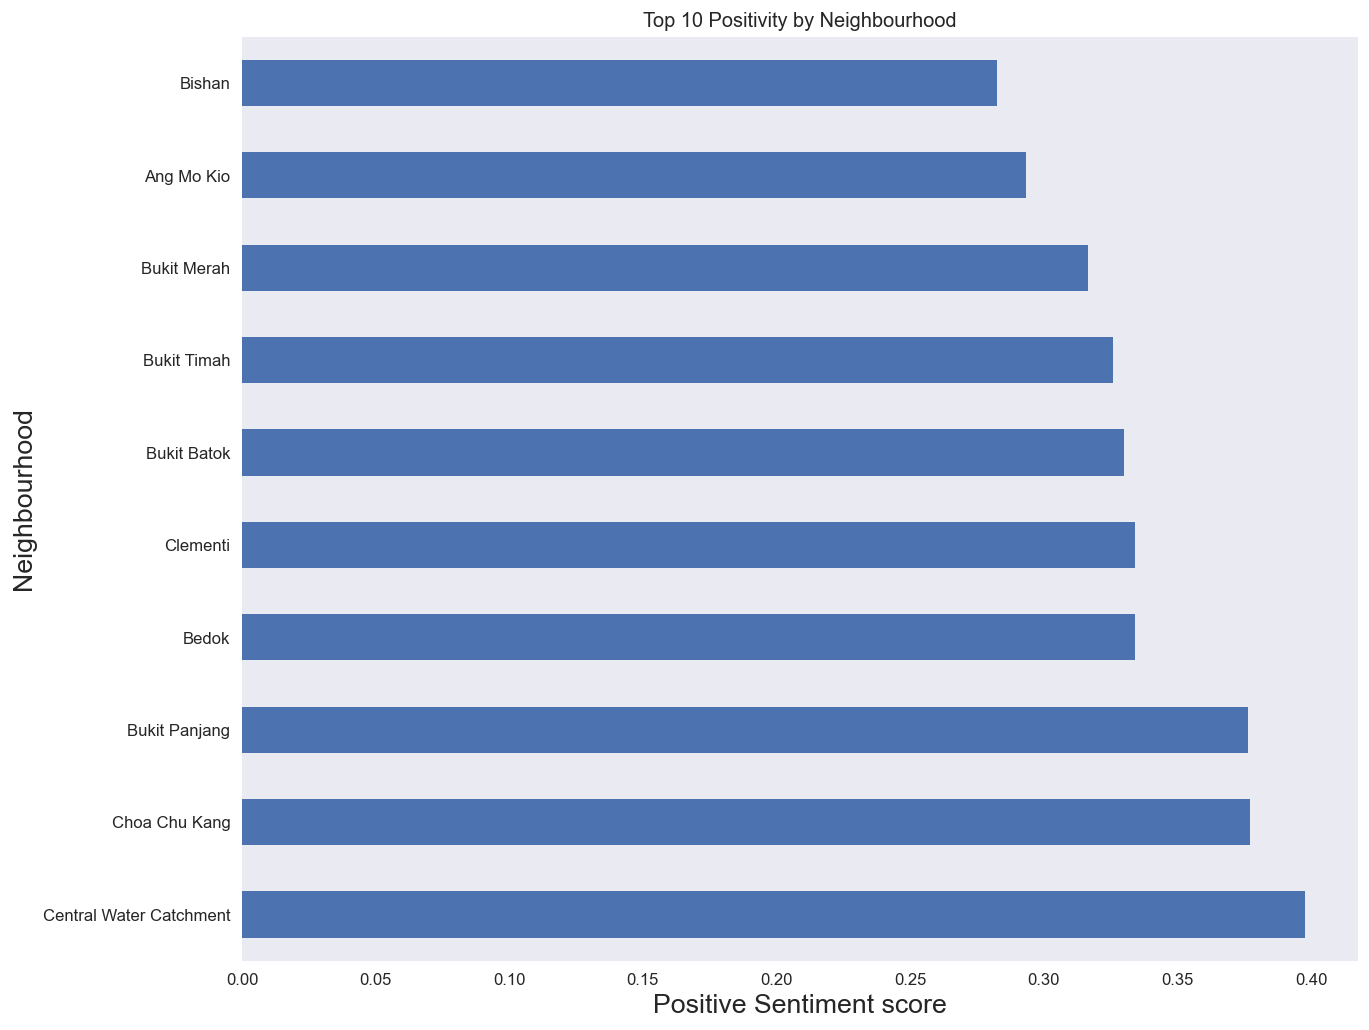

In [86]:
# Horizontal bar plot showing positivity with neighbourhood
plt.style.use('seaborn')
plt.figure(dpi = 120)
top_10 = neigh_sent.head(10).sort_values('Positive', ascending=False)
top_10['Positive'].plot(kind = 'barh',
           grid = False,
           title = 'Top 10 Positivity by Neighbourhood',
           figsize = (12,10))
plt.ylabel('Neighbourhood', fontsize = 16)
plt.xlabel('Positive Sentiment score', fontsize = 16)
plt.show()

#### Question 2: analysis: 
The neighbourhood with highest average positive reviews sentiment score is the Central Water Catchment area. Although with relatively lower number of listings, the Central Water Catchment area is home to the Singapore Zoo, and the 'Tree Top Walk' and other tourist destinations, with good connectivity to the center of the city. <br> <br>
Choa Chu Kang and Bukit Panjang are location very close to the Central Water Catchment as well. <br> <br>
Bedok and Clementi are neighbourhoods in the Eastern and Central zones, which also hosts the highest number of listings, and is close to Universal Studios and Sentosa island, and the Marina Bay Sands.

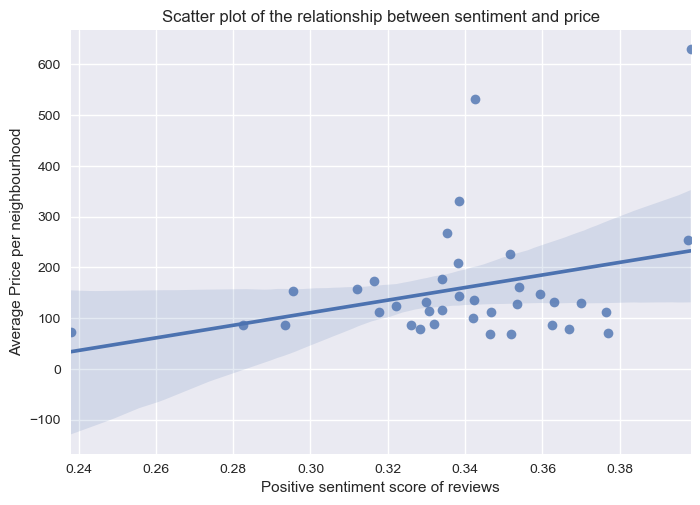

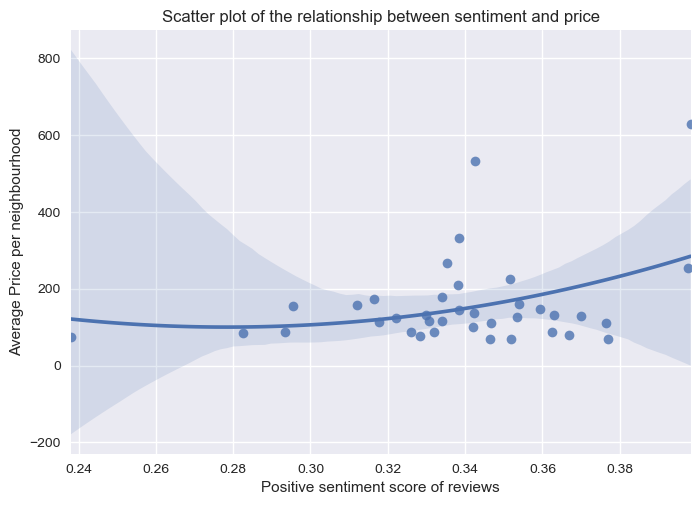

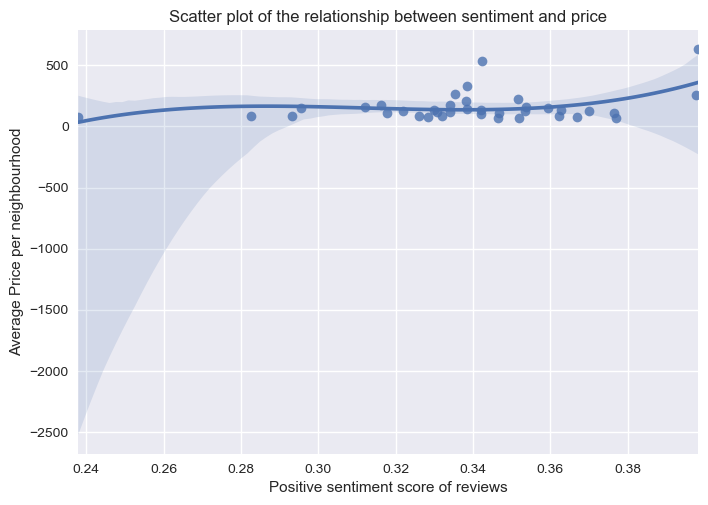

In [101]:
# We now use a scatter plot to show if there is some trend/correlation between
# average prices and positive sentiment of reviews to a neighbourhood

order = [1,2,3]
for i in order:
    plt.style.use('seaborn')
    sns.regplot(x = 'Positive',
            y = 'avg_price',
            data = neigh_sent, 
            order = i,
            marker = 'o')
    plt.ylabel('Average Price per neighbourhood')
    plt.xlabel('Positive sentiment score of reviews')
    plt.title('Scatter plot of the relationship between sentiment and price')
    plt.show()

#### Question 2.1. - analysis:
Seaborn's Regplot shows a scatter with a fit line to show the linear relation between positive sentiment in review scores and the average prices. However, this relationship may not be linear in nature, for several reasons. The effects of good reviews/good sentiment may not be reflected in the average price immediately. 
One improvement in this analysis could be using the relationship scatter plot for each listing separately and not by grouping them by neighbourhood, although this analysis is still useful.

In [104]:
data.dropna(inplace=True)

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684 entries, 0 to 2683
Data columns (total 43 columns):
host_response_rate                                2684 non-null float64
host_acceptance_rate                              2684 non-null float64
host_listings_count                               2684 non-null float64
accommodates                                      2684 non-null float64
beds                                              2684 non-null float64
price                                             2684 non-null float64
availability_365                                  2684 non-null float64
review_scores_value                               2684 non-null float64
reviews_per_month                                 2684 non-null float64
amenities_count                                   2684 non-null float64
host_is_superhost_f                               2684 non-null float64
host_is_superhost_t                               2684 non-null float64
host_has_profile_pic_f       

In [106]:
# Creating a numeric dataframe for conducting regression analysis
data_num = data.select_dtypes(include = ['integer', 'float'])
data_num.head()

,host_response_rate,host_acceptance_rate,host_listings_count,accommodates,beds,price,availability_365,review_scores_value,reviews_per_month,amenities_count,...,Compound,Negative,Neutral,Positive,days_available,availability_perc,max_price,min_price,avg_price,var_price
0,100.000000,79.903518,2.0,1.0,1.0,82.0,365.0,8.0,0.01,6.0,...,0.765000,0.000000,0.663000,0.337000,365.0,100.0,82.0,82.0,82.0,0.0
1,83.389189,79.903518,1.0,2.0,1.0,80.0,365.0,9.0,0.23,11.0,...,0.758878,0.030111,0.552889,0.417000,365.0,100.0,80.0,80.0,80.0,0.0
2,100.000000,79.903518,2.0,1.0,1.0,68.0,365.0,9.0,0.18,8.0,...,0.805815,0.036000,0.604000,0.360000,365.0,100.0,68.0,68.0,68.0,0.0
3,100.000000,100.000000,8.0,6.0,3.0,179.0,365.0,9.0,0.19,25.0,...,0.402585,0.076350,0.549500,0.274150,365.0,100.0,217.0,163.0,178.4,54.0
4,100.000000,100.000000,8.0,3.0,1.0,95.0,365.0,8.0,0.21,20.0,...,0.669129,0.011583,0.610292,0.294708,365.0,100.0,95.0,95.0,95.0,0.0


In [107]:
data_num.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'accommodates', 'beds', 'price', 'availability_365',
       'review_scores_value', 'reviews_per_month', 'amenities_count',
       'host_is_superhost_f', 'host_is_superhost_t', 'host_has_profile_pic_f',
       'host_has_profile_pic_t', 'neighbourhood_group_cleansed_Central Region',
       'neighbourhood_group_cleansed_East Region',
       'neighbourhood_group_cleansed_North Region',
       'neighbourhood_group_cleansed_North-East Region',
       'neighbourhood_group_cleansed_West Region', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'id', 'listing_id', 'Subjectivity', 'Polarity',
       'Compound', 'Negative', 'Neutral', 'Positive', 'days_available',
       'availability_perc', 'max_price', 'min_price', 'avg_price',
       'var_price'],
      dtype='object')

In [108]:
# Final data cleaning process before proceeding to the third question's analysis.
# the columns dropped here are unwated: either irrelevant to analysis, or is similar
# to existing variables.

data_num.drop(['availability_365', 'Subjectivity','id','listing_id',
              'Polarity','Compound','Negative','max_price','min_price',
              'availability_perc'], 1, inplace = True)
data_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684 entries, 0 to 2683
Data columns (total 27 columns):
host_response_rate                                2684 non-null float64
host_acceptance_rate                              2684 non-null float64
host_listings_count                               2684 non-null float64
accommodates                                      2684 non-null float64
beds                                              2684 non-null float64
price                                             2684 non-null float64
review_scores_value                               2684 non-null float64
reviews_per_month                                 2684 non-null float64
amenities_count                                   2684 non-null float64
host_is_superhost_f                               2684 non-null float64
host_is_superhost_t                               2684 non-null float64
host_has_profile_pic_f                            2684 non-null float64
host_has_profile_pic_t       

C:\Users\nit61\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [154]:
# Preparing the linear regression model to predict positive sentiment 
# scores of reviews for listing, based on several factors of the listings
# and the host themselves, as well as the regional characteristics.

Xpos = data_num.drop(['Positive'], 1)
ypos = data_num['Positive']
Xpos_train, Xpos_test, ypos_train, ypos_test = train_test_split(Xpos, ypos, test_size = 0.3, 
                                                               random_state = 42)

In [155]:
# Fitting, predicting and evaluating the linear regression model

lm_p = LinearRegression(normalize=True)
lm_pos = lm_p.fit(Xpos_train, ypos_train)
pred_pos = lm_pos.predict(Xpos_test)
accuracy_pos = r2_score(ypos_test, pred_pos)

print('The goodness of fit of the model is: {}'.format(accuracy_pos))
print('The error of the model is: {}'.format(np.sqrt(mean_squared_error(ypos_test, pred_pos))))

The goodness of fit of the model is: 0.3651549735623142
The error of the model is: 0.130134919530683


#### Question 3. 

#### The model's predictive power through the R-squared metric is a fair 36.5% goodness of fit, and a relatively low root mean squared error metric of 0.13